# Imports

In [1]:
# system
import os

# data manipulation
import pandas as pd
import numpy as np
# from scipy import stats
from sklearn.utils import resample

# plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots # used for secondary y-axis
import matplotlib.pyplot as plt

# Data preprocessing & data visualization
## Data preprocessing

In [2]:
# Get quantile of n zeros
def quantile(k):
    return 1 - 10**(-k)

In [3]:
# getting data from excel file
cwd = os.getcwd()
data = pd.read_excel(cwd + "/20201030_data.xlsx", sheet_name=1).iloc[2:,1:4]
data.columns = data.iloc[0]
data = data.iloc[1:]
data = data.reset_index(drop=True)
data.columns.name = None
data = data.convert_dtypes()

# getting statistics from excel file
st = pd.read_excel("20201030_data.xlsx", sheet_name=1, header=3).iloc[:1, 12:19]

# get bin width as variable since all bin width are the same
width = data["Width"][0]
data = data.drop(columns="Width")


results = np.repeat(data["Value"], data["Count"])
results = np.array(results)

In [4]:
# Compare computed and provided stats
df = st.copy().T
df.columns = ["provided"]

computed_stats = [np.nan, np.nan]
for i in range(3, 7):
    computed_stats.append(np.quantile(results, quantile(i)))
    
computed_stats.append(np.nan)
df["computed"] = computed_stats

df["difference"] = np.abs(df["computed"] - df["provided"])

## Data visualization
### Plotly

In [5]:
def histogram_plotly(show_cdf=True):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # make histogram
    hist = go.Histogram(x=results, histnorm="probability", name="Histogram", marker_color="#0f802d")
    fig.add_trace(hist)
    fig.update_layout(bargroupgap=.1) # space between bars
    if show_cdf:
        hist_cumul = go.Histogram(x=results, histnorm="probability", name="Cumul. histogram",
                                  cumulative_enabled=True, opacity=.25,)
        fig.add_trace(hist_cumul, secondary_y=True)
    return fig
histogram_plotly()

### Matplotlib

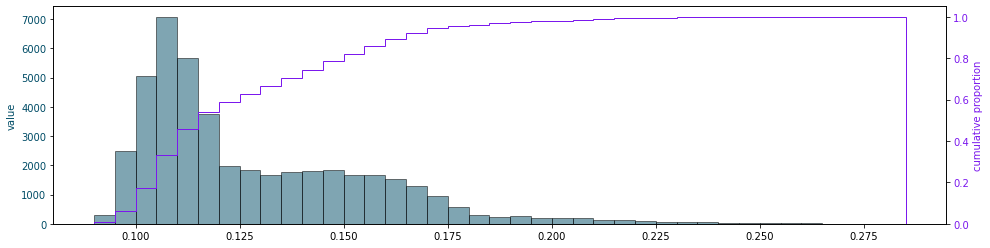

In [6]:
def histogram_plt():
    # Visual representation
    color1 = "#004C66"
    fig, ax = plt.subplots(figsize=(16,4))
    ax.hist(x=data["Value"], weights=data["Count"], bins=data["Value"], 
            alpha=0.5, ec='black', color=color1)
    ax.set_ylabel("value", color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    ax_cdf = ax.twinx()
    color2 = "#7b18ed"
    ax_cdf.hist(x=data["Value"], weights=data["Count"], bins=data["Value"],
                density=True, histtype='step', cumulative=True, label='Empirical', color = color2)
    ax_cdf.set_ylabel("cumulative proportion", color=color2)
    ax_cdf.tick_params(axis='y', labelcolor=color2)
    plt.close() #prevents figure showing twice
    return fig
histogram_plt()

On procède à `len(results)` tirages au sort depuis nos résultats et on note le quantile voulu. On répète la procédure un grand nombre de fois puis l'on prend la moyenne des quantiles. 

# Bootstrap
## Implementation

In [7]:
def bootstrap(q, n):
    # takes the q quantile from a resample of the results, repeats n times 
    boot = np.array([])
    for _ in range(n):
        r = resample(results)
        r_quantile = np.quantile(r, q, interpolation="linear")
        boot = np.append(boot, r_quantile)
    return boot

def hist_bootstrap(b):
    """takes an array with results from the bootstrap
    draws a histogram of the quantile value from the bootstrap"""
    fig = make_subplots()
    xbins = go.histogram.XBins(size=width/3)
    hist = go.Histogram(x=b, xbins=xbins)
    fig.add_trace(hist)
    fig.update_layout(title="Values of the quantile over all runs", xaxis_title="Value of the quantile", 
                      yaxis_title="Number of occurences", bargap=.05)
    return fig

def get_ci_bounds(boot, confidence_level):
    # returns array containing CI lower and upper bound at confidence_level
    bootstrap_sorted = np.sort(boot)
    # get bounds and compute safe quantiles
    lower_bound = np.quantile(bootstrap_sorted, (1 - confidence_level)/2)
    upper_bound = np.quantile(bootstrap_sorted, (confidence_level + (1 - confidence_level)/2))
    return [lower_bound, upper_bound]

def plot_moving_average(boot,confidence_level):
    first_resamples = [boot[:j] for j in range(1, len(boot)+1)]
    mean_first_resamples = [np.mean(first_res) for first_res in first_resamples] # the i-th element is an array with first i elements of boot
    # figure of moving average
    fig = go.Figure()
    ci_bounds = [get_ci_bounds(first_res, confidence_level) for first_res in first_resamples]
    fig.add_trace(go.Scatter(y=mean_first_resamples,name="estimation",))
    scatter_ci_upper = go.Scatter(name="Upper Bound", y=[bound[1] for bound in ci_bounds], showlegend=False, marker=dict(color="#444"), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)')
    scatter_ci_lower = go.Scatter(name="Lower Bound", y=[bound[0] for bound in ci_bounds], fill="tonexty", showlegend=False, marker=dict(color="#444"), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)')
    fig.add_trace(scatter_ci_upper)
    fig.add_trace(scatter_ci_lower)
    try:
        # get quantile provided by experiment software
        q_provided = st["Q" + str(k)][0]
        fig.add_trace(go.Scatter(x=[0, len(boot)-1],y=np.repeat(q_provided, 2),mode="lines",name="Provided value",visible="legendonly"))
    except Exception as e:
        print(e)
        # quantile is not provided 
        print(f"The true value of q{k} has not been found")
        
    fig.update_layout(xaxis_title="Number of runs",yaxis_title="Value of the quantile",showlegend=True)

    fig.add_trace(go.Scatter(x=[0, len(boot)-1],y=np.repeat(np.quantile(results + width/2, q), 2),mode="lines",name="Computed value",visible="legendonly"))
    return fig

## Confidence intervals

**Idea:** After bootstraping, say we want the 95% confidence interval. To get it, we simply order the results from the bootstrap, take the 2.5th percentile and the 97.5th percentile. The values between those percentiles are the bounds of our confidence interval.

Sources:
1. [Bootstrap confidence intervals - Jeremy Orloff and Jonathan Bloom][1] (excellent)
2. [Bootstrap Confidence Intervals - Joses Ho][2]
3. [Estimation of confidence intervals for quantiles in a finite population][3]

[1]: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
[2]: https://acclab.github.io/bootstrap-confidence-intervals.html#Introducing%20the%20bootstrap%20confidence%20interval&text=That%20is%20to%20say%2C%20we,difference%20by%20performing%20bootstrap%20resampling.
[3]: https://www.tandfonline.com/doi/pdf/10.3846/1392-6292.2008.13.195-202

In [8]:
for k in range(3,5):
    print(k)
    q = quantile(k)
    n = 2000
    boot = bootstrap(q, n)
    hist_bootstrap(boot)
    plot_moving_average(boot, .95).show()

3


4


## Compare with Normal distribution

In [11]:
histogram_plotly(False).add_trace(go.Histogram(x=np.random.normal(np.mean(results), np.std(results), len(results)), histnorm="probability", xbins=dict(size = 0.005),))